In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
from pathlib import Path
import json
import soundfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# test_path="/content/drive/MyDrive/classification_model/Thesis_experiments/chapter6/data/test.csv"
# train_path="/content/drive/MyDrive/classification_model/Thesis_experiments/chapter6/data/train.csv"

test_path="/content/drive/MyDrive/classification_model/Thesis_experiments/chapter4/FluecyBank/data/test.csv"
train_path="/content/drive/MyDrive/classification_model/Thesis_experiments/chapter4/FluecyBank/data/train.csv"

test=pd.read_csv(test_path)
test = test.iloc[1: , :]

train=pd.read_csv(train_path)
train = train.iloc[1: , :]

In [ ]:
# Drop first column of dataframe
test = test.iloc[: , 1:]

# Drop first column of dataframe
train = train.iloc[: , 1:]

In [ ]:
data=test.iloc[:,-8:]
clips = pd.DataFrame(data, columns= ['Show','EpId','clipId','P','B','S','W','I'])
clips

,Show,EpId,clipId,P,B,S,W,I
1,FluencyBank,193,84,1,0,1,0,0
2,FluencyBank,89,110,1,0,0,0,0
3,FluencyBank,97,3,1,0,0,0,0
4,FluencyBank,19,69,0,0,0,0,0
5,FluencyBank,985,37,0,1,0,0,1
...,...,...,...,...,...,...,...,...
151,FluencyBank,97,173,1,0,0,0,0
152,FluencyBank,985,171,0,0,0,1,0
153,FluencyBank,179,12,0,0,0,0,0
154,FluencyBank,89,19,0,0,1,0,1


In [ ]:
 def bulid_mfcc(signal,sr=8000,n_mfcc=20,hop_length=512,n_fft=2048):
    # mfcc=librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    mfcc=librosa.feature.mfcc(signal, sr, n_mfcc=n_mfcc, hop_length=int(0.010* sr), n_fft = int(0.025 * sr))
    return mfcc

In [ ]:
#Compute onset strength auto-correlation up to 3 seconds
def compute_autocorelation(signal,sample_rate,hop_length=512):
    odf = librosa.onset.onset_strength(y=signal, sr=sample_rate, hop_length=int(0.010* sample_rate))
    ac = librosa.autocorrelate(odf, max_size=3* sample_rate / int(0.010* sample_rate))
   
    return ac

def compute_zero_crossing_rate(signal,sample_rate):
  zero_crossing=librosa.feature.zero_crossing_rate(signal,hop_length=int(0.010* sample_rate),frame_length = int(0.025 * sample_rate)).T
   # zero_crossing=np.mean(librosa.feature.zero_crossing_rate(signal,pad=False).T,axis=0)
  return zero_crossing


def get_f0(signal,sample_rate):
  #extract F0 using yin
  # f0 = librosa.yin(signal, fmin = librosa.note_to_hz('C2'), fmax= librosa.note_to_hz('C7'))
  f0, voiced_flag, voiced_probs = librosa.pyin(signal, sr = sample_rate,hop_length=int(0.010* sample_rate),frame_length = int(0.025 * sample_rate), fmin = librosa.note_to_hz('C2'), fmax= librosa.note_to_hz('C7'))
  f0 = np.nan_to_num(f0)
  
  return f0,voiced_flag,voiced_probs 

In [ ]:
file_path="/content/drive/MyDrive/classification_model/sep28-clips/clips/StutteringIsCool/39/StutteringIsCool_39_22.wav"
#load time domain signal using librosa
signal,sample_rate=librosa.load(file_path,sr=8000, mono=True)
f0,voiced_flag,voiced_probs =get_f0(signal,sample_rate)
f0.shape

(301,)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


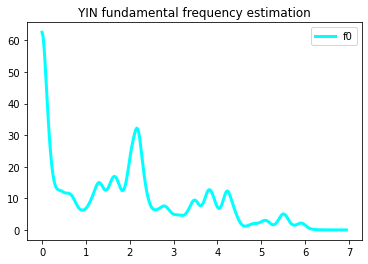

In [ ]:
#determine the file path
file_path="/content/drive/MyDrive/classification_model/fluencybank/source/FluencyBank/010/FluencyBank_010_3.wav"
#load time domain signal using librosa
signal,sample_rate=librosa.load(file_path,sr=8000, mono=True)

a=compute_autocorelation(signal,sample_rate)
times = librosa.times_like(a)

fig, ax = plt.subplots()
ax.set(title='YIN fundamental frequency estimation')
ax.plot(times, a, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')
plt.show()

In [ ]:
!pip install transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer,AutoFeatureExtractor,Wav2Vec2Model

import torch

# load model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wa

In [ ]:
# forward sample through model to get greedily predicted transcription ids
file='/content/drive/MyDrive/classification_model/fluencybank/source/FluencyBank/010/FluencyBank_010_3.wav'

def get_wav2vec_feature(file):

  signal,sample_rate=librosa.load(file,sr=16000, mono=True)
  input_values = feature_extractor(signal ,return_tensors="pt",requires_grad=True,sampling_rate=sample_rate).input_values
  print(input_values.shape)
  logits = model(input_values,output_hidden_states=True).hidden_states[0]
  print(logits.shape)
  pred_ids = torch.argmax(logits, axis=-1)
  return pred_ids


In [ ]:
import torchaudio
# wav2vec2.0
bundle = torchaudio.pipelines.WAV2VEC2_BASE
model_wav2vec = bundle.get_model()

In [ ]:
waveform, sample_rate = torchaudio.load(file)
# waveform = waveform.to(device)

emission, _ = model_wav2vec(waveform)

In [ ]:
emission.shape

torch.Size([1, 149, 768])

In [ ]:
#print(get_wav2vec_feature(file).detach().numpy())
print(get_wav2vec_feature(file))

torch.Size([1, 48000])
torch.Size([1, 149, 768])
tensor([[ 22, 352, 352, 352, 352, 352, 352, 734, 459, 352, 352, 352, 352, 352,
         352, 352, 352, 621, 241, 352, 352, 352, 352, 352, 352, 352, 352, 352,
         352, 241, 495, 241, 495, 241, 241, 241, 241, 241, 241, 352, 352, 352,
         352, 241, 241,  22, 241, 352, 352, 617, 617, 348, 734, 617, 688, 688,
         688, 688, 688, 688, 688, 688, 617, 617, 617, 617, 617, 617, 291, 291,
         617, 617, 617, 617,  96, 617, 617, 617, 617, 291, 617,  22,  22,  22,
         230, 468,  22,  22,  22,  22, 617, 352, 352, 352, 352, 352, 352, 617,
         348, 348,  96,  96,  96,  96, 688, 153, 153, 742, 459, 241, 731, 153,
         617, 617, 401, 700, 746, 700, 700, 153, 352, 352, 352, 352, 352, 241,
         269, 153, 153, 153, 153, 153, 153, 153, 247, 734, 632, 632, 632, 475,
           0, 477, 241, 241, 352, 352, 352, 366, 709]])


In [ ]:
# data_set_directory = '/content/drive/MyDrive/classification_model/sep28-clips/clips/'
data_set_directory = '/content/drive/MyDrive/classification_model/fluencybank/source/'
a=["%03d" % x for x in clips['EpId']]
clips['Path']= clips['Show']+'/'+a+'/'+clips['Show']+"_"+a+"_"+clips['clipId'].astype(str)+".wav"
# clips['Path']=clips['Show']+'/'+clips['EpId'].astype(str)+'/'+clips['Show']+"_"+clips['EpId'].astype(str)+"_"+clips['clipId'].astype(str)+".wav"

In [ ]:
clips

,Show,EpId,clipId,P,B,S,W,I,Path
1,FluencyBank,193,84,1,0,1,0,0,FluencyBank/193/FluencyBank_193_84.wav
2,FluencyBank,89,110,1,0,0,0,0,FluencyBank/089/FluencyBank_089_110.wav
3,FluencyBank,97,3,1,0,0,0,0,FluencyBank/097/FluencyBank_097_3.wav
4,FluencyBank,19,69,0,0,0,0,0,FluencyBank/019/FluencyBank_019_69.wav
5,FluencyBank,985,37,0,1,0,0,1,FluencyBank/985/FluencyBank_985_37.wav
...,...,...,...,...,...,...,...,...,...
151,FluencyBank,97,173,1,0,0,0,0,FluencyBank/097/FluencyBank_097_173.wav
152,FluencyBank,985,171,0,0,0,1,0,FluencyBank/985/FluencyBank_985_171.wav
153,FluencyBank,179,12,0,0,0,0,0,FluencyBank/179/FluencyBank_179_12.wav
154,FluencyBank,89,19,0,0,1,0,1,FluencyBank/089/FluencyBank_089_19.wav


In [ ]:
def load_data1():
  X,y=[],[]
  count = 0
  data=pd.DataFrame()
  
  for index, row in tqdm(clips.iterrows()):
    # print(data_set_directory+row['Path'])
    df=pd.DataFrame()
    if index<=200:
          # print(row['NoStutteredWords'])
          signal,sample_rate=librosa.load(data_set_directory+row['Path'],sr=8000)
          print(signal.shape)
          #check the duration of each clip
          if librosa.get_duration(y=signal, sr=sample_rate)==3:
            # spec = build_melspectogram(signal,sr=sample_rate, n_mels=64,n_fft=1024)
            spec = bulid_mfcc(signal,sample_rate,20)
            # print(spec.shape)
            # spec=get_features(data_set_directory+row['Path'])
            
            spec=spec.flatten()
            zc=compute_zero_crossing_rate(signal,sample_rate).flatten()
            ac=compute_autocorelation(signal,sample_rate,512)
           
            f0,voiced_flag,voiced_probs=get_f0(signal,sample_rate)
            asr=get_wav2vec_feature(data_set_directory+row['Path']).detach().numpy()
            asr=asr.flatten()
            # mfcc_mean=feature_mfcc(signal, sample_rate)

            # print(zc)
            feature_matrix = np.hstack((spec,zc,ac,f0,voiced_flag,voiced_probs,asr))
            # print(feature_matrix.shape)
            feature_matrix=pd.Series(feature_matrix)
            
        
            
            df=df.append(feature_matrix,ignore_index = True)
            # df=df.append(zc,ignore_index = True)
            df['Show']= row['Show']#row['Prolongation'],row['Block'],row['SoundRep'],row['WordRep'],row['Interjection'],row['NoStutteredWords']
            df['EpId']= row['EpId']
            df['clipId']= row['clipId']
            df['P']= row['P']
            df['B']= row['B']
            df['S']= row['S']
            df['W']= row['W']
            df['I']= row['I']
           

            data=pd.concat([data,df])
            # print(row['Path'])
            count =count+ 1
            print('\r' + f' Processed {count}/{3624} audio samples',end=' ')
          else:
              print(data_set_directory+row['Path'])

  return data          

In [ ]:
data=load_data1()

0it [00:00, ?it/s]

(24000,)


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
1it [00:05,  5.78s/it]

 Processed 1/3624 audio samples (24000,)


2it [00:12,  6.55s/it]

 Processed 2/3624 audio samples (24000,)


3it [00:19,  6.61s/it]

 Processed 3/3624 audio samples (24000,)


4it [00:24,  5.97s/it]

 Processed 4/3624 audio samples (24000,)


5it [00:29,  5.56s/it]

 Processed 5/3624 audio samples (24000,)


6it [00:34,  5.38s/it]

 Processed 6/3624 audio samples (24000,)


7it [00:39,  5.21s/it]

 Processed 7/3624 audio samples (24000,)


8it [00:44,  5.12s/it]

 Processed 8/3624 audio samples (24000,)


9it [00:48,  5.02s/it]

 Processed 9/3624 audio samples (24000,)


10it [00:53,  5.00s/it]

 Processed 10/3624 audio samples (24000,)


11it [00:58,  4.96s/it]

 Processed 11/3624 audio samples (24000,)


12it [01:04,  5.20s/it]

 Processed 12/3624 audio samples (24000,)


13it [01:09,  5.08s/it]

 Processed 13/3624 audio samples (24000,)


14it [01:14,  5.02s/it]

 Processed 14/3624 audio samples (24000,)


15it [01:19,  5.00s/it]

 Processed 15/3624 audio samples (24000,)


16it [01:24,  4.98s/it]

 Processed 16/3624 audio samples (24000,)


17it [01:28,  4.95s/it]

 Processed 17/3624 audio samples (24000,)


18it [01:33,  4.91s/it]

 Processed 18/3624 audio samples (24000,)


19it [01:38,  4.87s/it]

 Processed 19/3624 audio samples (24000,)


20it [01:44,  5.10s/it]

 Processed 20/3624 audio samples (24000,)


21it [01:49,  5.03s/it]

 Processed 21/3624 audio samples (24000,)


22it [01:54,  5.00s/it]

 Processed 22/3624 audio samples (24000,)


23it [01:59,  5.24s/it]

 Processed 23/3624 audio samples (24000,)


24it [02:05,  5.31s/it]

 Processed 24/3624 audio samples (24000,)


25it [02:10,  5.17s/it]

 Processed 25/3624 audio samples (24000,)


26it [02:15,  5.35s/it]

 Processed 26/3624 audio samples (24000,)


27it [02:21,  5.45s/it]

 Processed 27/3624 audio samples (24000,)


28it [02:26,  5.29s/it]

 Processed 28/3624 audio samples (24000,)


29it [02:31,  5.16s/it]

 Processed 29/3624 audio samples (24000,)


30it [02:36,  5.10s/it]

 Processed 30/3624 audio samples (24000,)


31it [02:41,  5.01s/it]

 Processed 31/3624 audio samples (24000,)


32it [02:46,  5.00s/it]

 Processed 32/3624 audio samples (24000,)


33it [02:51,  4.99s/it]

 Processed 33/3624 audio samples (24000,)


34it [02:56,  5.00s/it]

 Processed 34/3624 audio samples (24000,)


35it [03:00,  4.97s/it]

 Processed 35/3624 audio samples (24000,)


36it [03:05,  4.98s/it]

 Processed 36/3624 audio samples (24000,)


37it [03:10,  4.96s/it]

 Processed 37/3624 audio samples (24000,)


38it [03:15,  4.98s/it]

 Processed 38/3624 audio samples (24000,)


39it [03:20,  4.94s/it]

 Processed 39/3624 audio samples (24000,)


40it [03:25,  4.92s/it]

 Processed 40/3624 audio samples (24000,)


41it [03:31,  5.12s/it]

 Processed 41/3624 audio samples (24000,)


42it [03:36,  5.07s/it]

 Processed 42/3624 audio samples (24000,)


43it [03:40,  4.99s/it]

 Processed 43/3624 audio samples (24000,)


44it [03:45,  4.99s/it]

 Processed 44/3624 audio samples (24000,)


45it [03:50,  4.92s/it]

 Processed 45/3624 audio samples (24000,)


46it [03:55,  4.93s/it]

 Processed 46/3624 audio samples (24000,)


47it [04:00,  4.87s/it]

 Processed 47/3624 audio samples (24000,)


48it [04:05,  4.89s/it]

 Processed 48/3624 audio samples (24000,)


49it [04:10,  4.87s/it]

 Processed 49/3624 audio samples (24000,)


50it [04:15,  4.88s/it]

 Processed 50/3624 audio samples (24000,)


51it [04:19,  4.87s/it]

 Processed 51/3624 audio samples (24000,)


52it [04:25,  5.08s/it]

 Processed 52/3624 audio samples (24000,)


53it [04:31,  5.21s/it]

 Processed 53/3624 audio samples (24000,)


54it [04:35,  5.06s/it]

 Processed 54/3624 audio samples (24000,)


55it [04:40,  4.98s/it]

 Processed 55/3624 audio samples (24000,)


56it [04:45,  4.95s/it]

 Processed 56/3624 audio samples (24000,)


57it [04:50,  4.87s/it]

 Processed 57/3624 audio samples (24000,)


58it [04:54,  4.86s/it]

 Processed 58/3624 audio samples (24000,)


59it [04:59,  4.83s/it]

 Processed 59/3624 audio samples (24000,)


60it [05:04,  4.81s/it]

 Processed 60/3624 audio samples (24000,)


61it [05:09,  4.81s/it]

 Processed 61/3624 audio samples (24000,)


62it [05:14,  4.82s/it]

 Processed 62/3624 audio samples (24000,)


63it [05:19,  4.89s/it]

 Processed 63/3624 audio samples (24000,)


64it [05:24,  4.88s/it]

 Processed 64/3624 audio samples (24000,)


65it [05:28,  4.84s/it]

 Processed 65/3624 audio samples (24000,)


66it [05:33,  4.86s/it]

 Processed 66/3624 audio samples (24000,)


67it [05:38,  4.85s/it]

 Processed 67/3624 audio samples (24000,)


68it [05:43,  4.85s/it]

 Processed 68/3624 audio samples (24000,)


69it [05:48,  4.86s/it]

 Processed 69/3624 audio samples (24000,)


70it [05:53,  4.88s/it]

 Processed 70/3624 audio samples (24000,)


71it [05:57,  4.86s/it]

 Processed 71/3624 audio samples (24000,)


72it [06:02,  4.89s/it]

 Processed 72/3624 audio samples (24000,)


73it [06:07,  4.87s/it]

 Processed 73/3624 audio samples (24000,)


74it [06:12,  4.91s/it]

 Processed 74/3624 audio samples (24000,)


75it [06:17,  4.87s/it]

 Processed 75/3624 audio samples (24000,)


76it [06:22,  4.87s/it]

 Processed 76/3624 audio samples (24000,)


77it [06:27,  4.87s/it]

 Processed 77/3624 audio samples (24000,)


78it [06:32,  4.89s/it]

 Processed 78/3624 audio samples (24000,)


79it [06:37,  4.89s/it]

 Processed 79/3624 audio samples (24000,)


80it [06:41,  4.88s/it]

 Processed 80/3624 audio samples (24000,)


81it [06:46,  4.84s/it]

 Processed 81/3624 audio samples (24000,)


82it [06:52,  5.19s/it]

 Processed 82/3624 audio samples (24000,)


83it [06:57,  5.15s/it]

 Processed 83/3624 audio samples (24000,)


84it [07:02,  5.05s/it]

 Processed 84/3624 audio samples (24000,)


85it [07:07,  4.98s/it]

 Processed 85/3624 audio samples (24000,)


86it [07:12,  4.93s/it]

 Processed 86/3624 audio samples (24000,)


87it [07:17,  4.90s/it]

 Processed 87/3624 audio samples (24000,)


88it [07:21,  4.89s/it]

 Processed 88/3624 audio samples (24000,)


89it [07:26,  4.83s/it]

 Processed 89/3624 audio samples (24000,)


90it [07:31,  4.81s/it]

 Processed 90/3624 audio samples (24000,)


91it [07:36,  4.79s/it]

 Processed 91/3624 audio samples (24000,)


92it [07:40,  4.79s/it]

 Processed 92/3624 audio samples (24000,)


93it [07:45,  4.78s/it]

 Processed 93/3624 audio samples (24000,)


94it [07:50,  4.69s/it]

 Processed 94/3624 audio samples (24000,)


95it [07:54,  4.73s/it]

 Processed 95/3624 audio samples (24000,)


96it [07:59,  4.64s/it]

 Processed 96/3624 audio samples (24000,)


97it [08:04,  4.68s/it]

 Processed 97/3624 audio samples (24000,)


98it [08:08,  4.62s/it]

 Processed 98/3624 audio samples (24000,)


99it [08:13,  4.67s/it]

 Processed 99/3624 audio samples (24000,)


100it [08:17,  4.61s/it]

 Processed 100/3624 audio samples (24000,)


101it [08:22,  4.73s/it]

 Processed 101/3624 audio samples (24000,)


102it [08:27,  4.66s/it]

 Processed 102/3624 audio samples (24000,)


103it [08:32,  4.70s/it]

 Processed 103/3624 audio samples (24000,)


104it [08:36,  4.65s/it]

 Processed 104/3624 audio samples (24000,)


105it [08:41,  4.68s/it]

 Processed 105/3624 audio samples (24000,)


106it [08:45,  4.63s/it]

 Processed 106/3624 audio samples (24000,)


107it [08:50,  4.69s/it]

 Processed 107/3624 audio samples (24000,)


108it [08:55,  4.63s/it]

 Processed 108/3624 audio samples (24000,)


109it [09:00,  4.67s/it]

 Processed 109/3624 audio samples (24000,)


110it [09:04,  4.66s/it]

 Processed 110/3624 audio samples (24000,)


111it [09:09,  4.71s/it]

 Processed 111/3624 audio samples (24000,)


112it [09:13,  4.63s/it]

 Processed 112/3624 audio samples (24000,)


113it [09:19,  5.01s/it]

 Processed 113/3624 audio samples (24000,)


114it [09:24,  4.87s/it]

 Processed 114/3624 audio samples (24000,)


115it [09:29,  4.84s/it]

 Processed 115/3624 audio samples (24000,)


116it [09:33,  4.71s/it]

 Processed 116/3624 audio samples (24000,)


117it [09:38,  4.71s/it]

 Processed 117/3624 audio samples (24000,)


118it [09:42,  4.63s/it]

 Processed 118/3624 audio samples (24000,)


119it [09:47,  4.67s/it]

 Processed 119/3624 audio samples (24000,)


120it [09:52,  4.65s/it]

 Processed 120/3624 audio samples (24000,)


121it [09:56,  4.72s/it]

 Processed 121/3624 audio samples (24000,)


122it [10:01,  4.68s/it]

 Processed 122/3624 audio samples (24000,)


123it [10:06,  4.74s/it]

 Processed 123/3624 audio samples (24000,)


124it [10:11,  4.68s/it]

 Processed 124/3624 audio samples (24000,)


125it [10:15,  4.72s/it]

 Processed 125/3624 audio samples (24000,)


126it [10:20,  4.67s/it]

 Processed 126/3624 audio samples (24000,)


127it [10:25,  4.72s/it]

 Processed 127/3624 audio samples (24000,)


128it [10:29,  4.66s/it]

 Processed 128/3624 audio samples (24000,)


129it [10:34,  4.70s/it]

 Processed 129/3624 audio samples (24000,)


130it [10:39,  4.64s/it]

 Processed 130/3624 audio samples (24000,)


131it [10:43,  4.68s/it]

 Processed 131/3624 audio samples (24000,)


132it [10:48,  4.65s/it]

 Processed 132/3624 audio samples (24000,)


133it [10:53,  4.70s/it]

 Processed 133/3624 audio samples (24000,)


134it [10:57,  4.66s/it]

 Processed 134/3624 audio samples (24000,)


135it [11:02,  4.70s/it]

 Processed 135/3624 audio samples (24000,)


136it [11:06,  4.58s/it]

 Processed 136/3624 audio samples (24000,)


137it [11:11,  4.62s/it]

 Processed 137/3624 audio samples (24000,)


138it [11:16,  4.58s/it]

 Processed 138/3624 audio samples (24000,)


139it [11:20,  4.64s/it]

 Processed 139/3624 audio samples (24000,)


140it [11:25,  4.56s/it]

 Processed 140/3624 audio samples (24000,)


141it [11:30,  4.65s/it]

 Processed 141/3624 audio samples (24000,)


142it [11:34,  4.59s/it]

 Processed 142/3624 audio samples (24000,)


143it [11:39,  4.63s/it]

 Processed 143/3624 audio samples (24000,)


144it [11:44,  4.96s/it]

 Processed 144/3624 audio samples (24000,)


145it [11:50,  5.07s/it]

 Processed 145/3624 audio samples (24000,)


146it [11:55,  4.99s/it]

 Processed 146/3624 audio samples (24000,)


147it [11:59,  4.94s/it]

 Processed 147/3624 audio samples (24000,)


148it [12:04,  4.92s/it]

 Processed 148/3624 audio samples (24000,)


149it [12:09,  4.87s/it]

 Processed 149/3624 audio samples (24000,)


150it [12:14,  4.88s/it]

 Processed 150/3624 audio samples (24000,)


151it [12:19,  4.87s/it]

 Processed 151/3624 audio samples (24000,)


152it [12:24,  4.83s/it]

 Processed 152/3624 audio samples (24000,)


153it [12:28,  4.83s/it]

 Processed 153/3624 audio samples (24000,)


154it [12:33,  4.80s/it]

 Processed 154/3624 audio samples (24000,)


155it [12:38,  4.89s/it]

 Processed 155/3624 audio samples 

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,12290,12291,Show,EpId,clipId,P,B,S,W,I
0,-527.270386,-514.933167,-521.912109,-522.719543,-517.822021,-515.221985,-511.038849,-526.431152,-534.028564,-514.209900,...,-6.685979,-5.566538,FluencyBank,193,84,1,0,1,0,0
0,-603.023743,-560.952087,-572.296692,-593.399536,-602.373169,-628.780640,-609.912109,-624.694763,-607.717102,-599.533936,...,-6.016302,-5.767938,FluencyBank,89,110,1,0,0,0,0
0,-608.871826,-599.735107,-583.368286,-605.024292,-594.177734,-585.532654,-587.486694,-584.078918,-580.879761,-604.866455,...,-5.573888,-6.125316,FluencyBank,97,3,1,0,0,0,0
0,-633.213318,-632.018433,-644.609741,-628.425415,-648.096558,-635.528809,-622.250427,-627.535217,-620.938721,-618.580383,...,-5.281829,-6.172150,FluencyBank,19,69,0,0,0,0,0
0,-634.457214,-639.167175,-639.650696,-647.885742,-643.025696,-637.744690,-646.830383,-638.263367,-638.781921,-663.842468,...,-5.972605,-8.189253,FluencyBank,985,37,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-588.396240,-583.301392,-585.878540,-581.452698,-589.420349,-590.721558,-586.467834,-586.627563,-581.060303,-596.444458,...,-6.664877,-4.075761,FluencyBank,97,173,1,0,0,0,0
0,-531.223083,-604.957520,-546.610168,-488.695007,-473.125122,-453.748138,-446.819611,-429.245667,-417.462036,-420.519287,...,-8.032270,-9.278920,FluencyBank,985,171,0,0,0,1,0
0,-383.112732,-405.355347,-442.836761,-445.657623,-447.281342,-445.068756,-435.973755,-415.621613,-435.082916,-458.461670,...,-8.293589,-6.998707,FluencyBank,179,12,0,0,0,0,0
0,-593.716553,-570.966980,-545.803833,-552.366943,-551.303589,-538.580200,-526.223022,-537.011475,-550.114990,-537.104980,...,-8.585789,-7.414951,FluencyBank,89,19,0,0,1,0,1


In [ ]:
# This function to save data features and labels.
# By Kareem
def save_data(data,path):
  data.to_csv(path,index=False)
save_data(data,"/content/drive/MyDrive/classification_model/Thesis_experiments/extra_experiments/optimized_model/data/test_fb_new.csv")